#### Imports

In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import transform


#### Fonctions utilitaires pour parcourir les images

In [48]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            folder_path = os.path.join(common_path, subfolder, category)
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img, category, file_name)

                
def display_imgs(imgs, titles = [], plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [3]:
all_images = []
all_categories = []

datasetX = []
datasetY = []

image_size = (200, 200)

def load_datasets(img, category, file_name):
    if category == "PNEUMONIA":
        if "virus" in file_name:
            category = "VIRUS PNEUMONIA"
        elif "bacteria" in file_name:
            category = "BACTERIA PNEUMONIA"
    else:
        category = "NORMAL"
    
    new_img = cv2.resize(img, image_size)
    all_images.append(new_img)
    all_categories.append(category)

browse_imgs(load_datasets)

##### Doubler le dataset d'images NORMAL

In [4]:
# Définir une fonction pour effectuer une rotation d'image
def rotate_image(image, angle):
    return transform.rotate(image, angle)

# Définir une fonction pour effectuer un retournement horizontal d'image
def flip_image(image):
    return image[:, ::-1]

normal_indice = []
print("Normal indices size : ", len(normal_indice))

# Créer une liste pour stocker les indices des images "NORMAL"
normal_indice = [i for i, category in enumerate(all_categories) if category == "NORMAL"]

print("Normal indices size : ", len(normal_indice))

# Pour chaque image "NORMAL"...
for i in normal_indice:
    img = all_images[i]

    # Effectuer une rotation de 20 degrés, redimensionner l'image et l'ajouter à la liste de toutes les images
    rotated_img = rotate_image(img, 20)
    resized_rotated_img = cv2.resize(rotated_img, image_size)
    all_images.append(resized_rotated_img)
    all_categories.append("NORMAL")

    # Effectuer un retournement horizontal, redimensionner l'image et l'ajouter à la liste de toutes les images
    flipped_img = flip_image(img)
    resized_flipped_img = cv2.resize(flipped_img, image_size)
    all_images.append(resized_flipped_img)
    all_categories.append("NORMAL")

# Convert the list of all images to a numpy array
datasetX = np.array(all_images)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)

use_all_dataset()
print("Dataset all shape : ", datasetX.shape)

Normal indices size :  0
Normal indices size :  1583
Dataset all shape :  (9022, 200, 200)


#### Classification Report

In [51]:
from sklearn.metrics import classification_report

# Génération du rapport de classification
report = classification_report(testy, y_pred, target_names=labels)
print(report)

                    precision    recall  f1-score   support

            NORMAL       0.69      0.82      0.75       549
   VIRUS PNEUMONIA       0.94      0.80      0.87       956
BACTERIA PNEUMONIA       0.74      0.77      0.76       897

          accuracy                           0.80      2402
         macro avg       0.79      0.80      0.79      2402
      weighted avg       0.81      0.80      0.80      2402



#### CNN - Convolution Neural Network

##### Les imports

In [5]:
import visualkeras as vk
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

##### Le modèle

Convolution = mettre en évidence les caractéristiques de l'image.

Poolling = réduire l'image.

In [42]:
num_classes = 3
core_size = 4

model = tf.keras.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(128, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, core_size, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# model.summary()

In [47]:
datasetX = np.array(all_images)
datasetY = np.array(all_categories)

xtrain, otherX, ytrain, otherY = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xval, testx, yval, testy = train_test_split(otherX, otherY, test_size=0.5, random_state=1)

xtrain = xtrain / 255
testx = testx / 255
xval = xval / 255

print(xtrain.shape)
print(testx.shape)
print(xval.shape)

label_to_index = {"NORMAL": 0, "VIRUS PNEUMONIA": 1, "BACTERIA PNEUMONIA": 2}
ytrain = np.array([label_to_index[y] for y in ytrain])
testy = np.array([label_to_index[y] for y in testy])
yval = np.array([label_to_index[y] for y in yval])

print(ytrain.shape)
print(testy.shape)
print(yval.shape)
random_indices = np.random.choice(ytrain.shape[0], 20, replace=False)
print(ytrain[random_indices])

model.fit(xtrain,
    ytrain,
    validation_data=(xval, yval),
    epochs=2)

(7217, 200, 200)
(903, 200, 200)
(902, 200, 200)
(7217,)
(903,)
(902,)
[0 0 2 1 0 1 2 2 2 2 2 2 0 2 2 0 2 2 0 2]
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.      

InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 639, in run_forever

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1985, in _run_once

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\fvenezia\AppData\Local\Temp\ipykernel_25516\449487511.py", line 26, in <module>

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 314, in fit

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 117, in one_step_on_iterator

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 104, in one_step_on_data

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 73, in train_step

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 412, in compute_metrics

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 330, in update_state

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 17, in update_state

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\metrics\confusion_metrics.py", line 522, in update_state

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 592, in update_confusion_matrix_variables

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 565, in weighted_assign_add

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\numpy.py", line 3242, in logical_and

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1409, in logical_and

Incompatible shapes: [1,96] vs. [1,32]
	 [[{{node LogicalAnd}}]] [Op:__inference_one_step_on_iterator_18618]

##### L'entrainement

In [50]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['recall', 'precision'])

In [51]:
datasetX = np.array(all_images)
datasetY = np.array(all_categories)

xtrain, otherX, ytrain, otherY = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xval, testx, yval, testy = train_test_split(otherX, otherY, test_size=0.5, random_state=1)

xtrain = xtrain / 255
testx = testx / 255
xval = xval / 255

print(xtrain.shape)
print(testx.shape)
print(xval.shape)

label_to_index = {"NORMAL": 0, "VIRUS PNEUMONIA": 1, "BACTERIA PNEUMONIA": 2}
ytrain = np.array([label_to_index[y] for y in ytrain])
testy = np.array([label_to_index[y] for y in testy])
yval = np.array([label_to_index[y] for y in yval])

print(ytrain.shape)
print(testy.shape)
print(yval.shape)
random_indices = np.random.choice(ytrain.shape[0], 20, replace=False)
print(ytrain[random_indices])

model.fit(xtrain,
    ytrain,
    validation_data=(xval, yval),
    epochs=2)

(7217, 200, 200)
(903, 200, 200)
(902, 200, 200)
(7217,)
(903,)
(902,)
[2 2 2 2 0 0 2 2 0 0 0 1 0 2 0 2 0 0 0 0]
Epoch 1/2


c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 639, in run_forever

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1985, in _run_once

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\fvenezia\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\fvenezia\AppData\Local\Temp\ipykernel_25516\449487511.py", line 26, in <module>

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 314, in fit

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 117, in one_step_on_iterator

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 104, in one_step_on_data

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 73, in train_step

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 412, in compute_metrics

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 330, in update_state

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 17, in update_state

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\metrics\confusion_metrics.py", line 522, in update_state

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 592, in update_confusion_matrix_variables

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 565, in weighted_assign_add

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\numpy.py", line 3242, in logical_and

  File "c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1409, in logical_and

Incompatible shapes: [1,96] vs. [1,32]
	 [[{{node LogicalAnd}}]] [Op:__inference_one_step_on_iterator_20720]

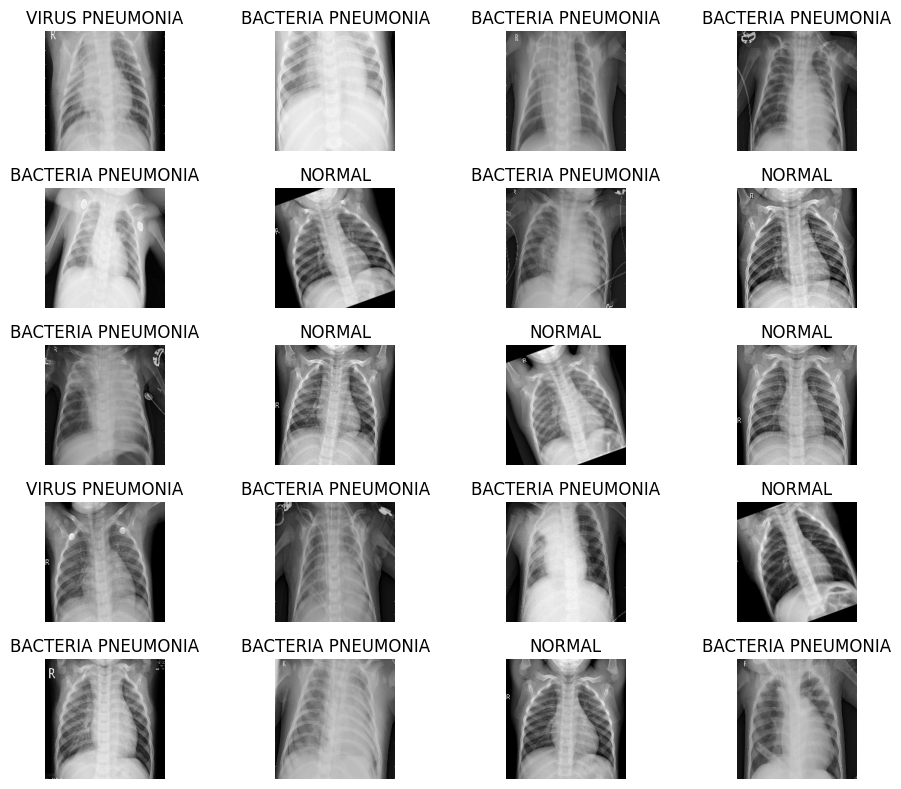

In [58]:
num_imgs_to_display = 20

random_indices = np.random.choice(len(datasetX), num_imgs_to_display, replace=False)

# Extract images and titles using the selected indices
selected_imgs = [datasetX[idx] for idx in random_indices]
selected_titles = [datasetY[idx] for idx in random_indices]

# Calculate grid size for the subplot
# For simplicity, creating a 2x2 grid if displaying 4 images
plot_size = (5, 4)  # Adjust based on num_imgs_to_display

display_imgs(selected_imgs, titles=selected_titles, plot_size=plot_size, figsize=(10, 8))

In [49]:
print(model.evaluate(testx, testy))

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1050 - precision_4: 0.9250 - recall_4: 0.9789
[0.1058962270617485, 0.976190447807312, 0.9360730648040771]


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


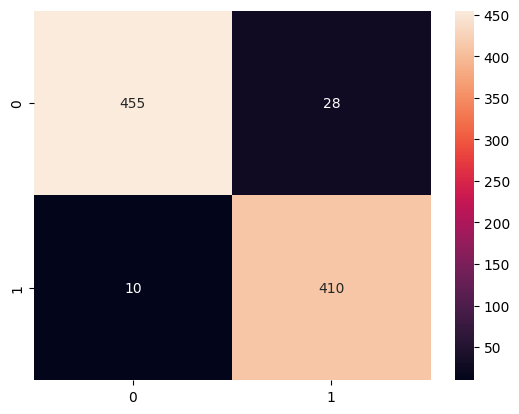

[[455  28]
 [ 10 410]]
recall :  0.9761904761904762
precision :  0.9360730593607306
f1score :  0.9557109557109557


In [50]:
y_pred = model.predict(testx)

y_pred_label = np.argmax(y_pred, axis=1)

cm = confusion_matrix(testy, y_pred_label)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(cm)
recall = recall_score(testy, y_pred_label, average='macro')  # Ajout de average='macro' pour multi-classe
precision = precision_score(testy, y_pred_label, average='macro')
f1score = f1_score(testy, y_pred_label, average='macro')
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)